In [1]:
import numpy as np
from scipy.stats import entropy

from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import FullNestedArrayOfProbabilities
from probability_distributions import JointProbabilityMatrixExtended
import probability_distributions
from probability_distributions import ProbabilityArray

In [2]:
def nudge(distribution, nudge_size):
    """
    Perform a nudge on the distribution. For now the nudge
    is performed on two randomly selected states
    
    Parameters:
    ----------
    distribution: a 1-d numpy array
    nudge_size:  a positive number
        The size of the nudge
    
    Returns: the nudged distribution
    """
    nudged_states = np.random.choice(distribution.shape[0],
                                     size=2, 
                                     replace=False)
    nudge_size = min(nudge_size, 
                     1-distribution[nudged_states[0]],
                     distribution[nudged_states[1]])
    
    nudged_distribution = np.copy(distribution)
    nudged_distribution[nudged_states[0]] += nudge_size
    nudged_distribution[nudged_states[1]] -= nudge_size
    return nudged_distribution

def test_nudge1():
    distribution = np.array([0.3, 0.4, 0.3, 0.1])
    sum_nudged_distribution = np.zeros(distribution.shape)
    for i in range(5):
        print(nudge(distribution, 0.01))
        
def test_nudge2():
    distribution = np.array([0.001, 0.001, 0.003, 0.995])
    sum_nudged_distribution = np.zeros(distribution.shape)
    for i in range(10):
        assert np.all(nudge(distribution, 0.01) >= 0)
        assert np.all(nudge(distribution, 0.01) <= 1)
    
test_nudge1()
test_nudge2()
        
    

[ 0.3   0.39  0.31  0.1 ]
[ 0.3   0.4   0.31  0.09]
[ 0.31  0.39  0.3   0.1 ]
[ 0.29  0.41  0.3   0.1 ]
[ 0.29  0.41  0.3   0.1 ]


In [3]:
pdf = JointProbabilityMatrix(1, 6, 'random')
#print(pdf.joint_probabilities.joint_probabilities)
pdf.append_variables_with_target_mi(1, 0.8)


In [4]:
NUDGE_SIZE = 0.01

pdf = JointProbabilityMatrix(1, 6, 'random')
#print(pdf.joint_probabilities.joint_probabilities)
pdf.append_variables_with_target_mi(1, 0.1)
#print(pdf.joint_probabilities.joint_probabilities)
#print(pdf.mutual_information([0], [1]))

joint_old = pdf.joint_probabilities.joint_probabilities
probability_array_old = ProbabilityArray(joint_old)
marginal_variable_old = probability_array_old.marginalize(set([0]))
marginal_function_old = probability_array_old.marginalize(set([1]))
conditional_joint_old, marginal_labels_old, conditional_labels_old = (
    probability_array_old.find_conditional(set([1]), set([0]))
)
#print(marginal_variable_old)
#print(np.allclose(
#    probability_distributions.compute_joint(
#        marginal_variable_old, conditional_joint_old, conditional_labels_old
#    ),
#    joint_old
#))
marginal_variable_nudged = nudge(marginal_variable_old, NUDGE_SIZE)
joint_new = ProbabilityArray(probability_distributions.compute_joint(
    marginal_variable_nudged, conditional_joint_old, conditional_labels_old
))
#This takes the KL-divergence between the new and old function variable
marginal_function_new = joint_new.marginalize(set([1]))  

kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
kl_function = entropy(marginal_function_old, marginal_function_new) 
print("KL-divergence old and new function distribution: {}".format(kl_variable))
print("KL-divergence old and new function distribution: {}".format(kl_function))




KL-divergence old and new function distribution: 0.000582751636219
KL-divergence old and new function distribution: 1.02162626993e-05


In [5]:
def effect_of_nudge(number_of_states, mutual_information, nudge_size):
    pdf = JointProbabilityMatrix(1, number_of_states, 'random')
    pdf.append_variables_with_target_mi(1, mutual_information)
    joint_old = pdf.joint_probabilities.joint_probabilities
    probability_array_old = ProbabilityArray(joint_old)
    marginal_variable_old = probability_array_old.marginalize(set([0]))
    marginal_function_old = probability_array_old.marginalize(set([1]))
    conditional_joint_old, marginal_labels_old, conditional_labels_old = (
        probability_array_old.find_conditional(set([1]), set([0]))
    )
    marginal_variable_nudged = nudge(marginal_variable_old, NUDGE_SIZE)
    joint_new = ProbabilityArray(probability_distributions.compute_joint(
        marginal_variable_nudged, conditional_joint_old, conditional_labels_old
    ))
    marginal_function_new = joint_new.marginalize(set([1]))  
    kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
    kl_function = entropy(marginal_function_old, marginal_function_new) 
    return kl_variable, kl_function

effect_of_nudge(4, 0.1, 0.01)

(0.00041394516664005655, 2.0356021032248012e-05)

In [13]:
#see whether and how mutual information and response to the nudge co-depend
NUMBER_OF_STATES, NUDGE_SIZE = 6, 0.01
mutual_information_sizes = np.arange(0.05, 1, 0.05)
sample_size = 100
average_effect_nudge = {}

for mutual_information_size in mutual_information_sizes:
    print("the mutual information size is {}".format(mutual_information_size))
    nudge_effects = []
    for sample in range(sample_size):
        nudge_effects.append(
            effect_of_nudge(4, mutual_information_size, 0.01)[1]
        )
    average_effect_nudge[mutual_information_size] = np.mean(nudge_effects)
    
print(average_effect_nudge)

the mutual information size is 0.05
the mutual information size is 0.1
the mutual information size is 0.15
the mutual information size is 0.2
the mutual information size is 0.25
the mutual information size is 0.3
the mutual information size is 0.35
the mutual information size is 0.4
the mutual information size is 0.45
the mutual information size is 0.5
the mutual information size is 0.55
the mutual information size is 0.6
the mutual information size is 0.65
the mutual information size is 0.7
the mutual information size is 0.75
the mutual information size is 0.8
the mutual information size is 0.85
the mutual information size is 0.9
the mutual information size is 0.95
{0.25: 5.7966754692180996e-05, 0.5: 0.00011428205737884133, 0.10000000000000001: 2.1336850830856365e-05, 0.20000000000000001: 4.2257068734944147e-05, 0.40000000000000002: 0.00010511201412329804, 0.15000000000000002: 3.3865339070814593e-05, 0.80000000000000004: 0.00016951478109272471, 0.29999999999999999: 7.2373738180670703e

{0.25: 5.7966754692180996e-05, 0.5: 0.00011428205737884133, 0.10000000000000001: 2.1336850830856365e-05, 0.20000000000000001: 4.2257068734944147e-05, 0.40000000000000002: 0.00010511201412329804, 0.15000000000000002: 3.3865339070814593e-05, 0.80000000000000004: 0.00016951478109272471, 0.29999999999999999: 7.2373738180670703e-05, 0.050000000000000003: 1.1741001193329332e-05, 0.90000000000000013: 0.00019885355927691458, 0.95000000000000007: 0.0002272772709557917, 0.65000000000000013: 0.00012772707192321329, 0.85000000000000009: 0.00023392036949476224, 0.45000000000000001: 0.00010428433054772715, 0.60000000000000009: 0.00012336099665904171, 0.75000000000000011: 0.00015969536379837029, 0.70000000000000007: 0.00014666946682441695, 0.35000000000000003: 8.4959104301778366e-05, 0.55000000000000004: 0.0001196016337054747}
OrderedDict([(0.050000000000000003, 1.1741001193329332e-05), (0.10000000000000001, 2.1336850830856365e-05), (0.15000000000000002, 3.3865339070814593e-05), (0.20000000000000001,

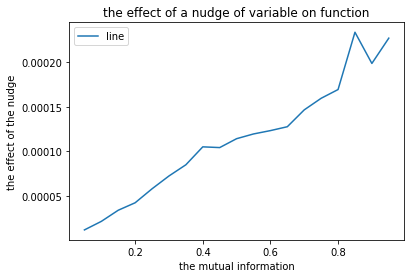

In [14]:
import matplotlib.pyplot as plt
import collections

print(average_effect_nudge)
ord_dict_val = collections.OrderedDict(sorted(average_effect_nudge.items(), key= lambda x: x[0]))
print(ord_dict_val)

a = ord_dict_val.keys()
b = ord_dict_val.values()

plt.plot(a, b, label="line")
plt.xlabel("the mutual information")
plt.ylabel("the effect of the nudge")
plt.legend()
plt.title("the effect of a nudge of variable on function")
plt.show()

In [ ]:
import numpy as np

probability_array_tryout = FullNestedArrayOfProbabilities(
    np.array(
      [
        [
          [
            [0.2, 0.1]          
          ],
          [
            [0.05, 0.05]
          ]
        ],
        [
          [
            [0.3, 0.05] 
          ],
          [
            [0.15, 0.1] 
          ]
        ],
      ]
    )
)
pdf_tryout = JointProbabilityMatrixExtended(4, 2, probability_array_tryout)

print("the joint pdf")
print(pdf_tryout.dist())

probability_dict = 

pdf_tryout.conditional_distribution([3], [0, 2])

In [ ]:
def conditional_distribution(self, selected_indices, conditional_indices):
    """create the conditional distribution for the selected_indices given 
    the conditional_indices for the joint_distribution
    
    Parameters:
    ----------
    joint_distribution: numpy array
    selected_indices: list of integers
    conditional_indices: list of integers
    
    Returns:
    -------
    
    """
    joint_distribution = self.marginalize_distribution(selected_indices+conditional_indices)
    marginal_conditional = self.marginalize_distribution(conditional_indices)
    conditional_distribution = np.copy(joint_distribution) 
    it = np.iter(joint_distribution, flags='multi_index')
    while not it.finished:
        conditional_arguments = tuple([it.multi_index[i] for i in conditional_indices])
        conditional_distribution[it.multi_index] = (
            conditional_distribution[it.multi_index] /
            marginal_conditional[conditional_arguments]
        )
        it.iternext()
        
    return conditional_distribution
        

In [ ]:
import numpy as np 

a = np.array(
    [
        [1, 10],
        [50, 100]
    ]
)

b = np.array(
    [
        [
            [10, 20],
            [30, 40]
        ],
        [
            [1, 2],
            [3, 4]
        ]
    ]
)

a*b 

In [ ]:
import numpy as np

tryout = np.arange(2**10).reshape([2]*10)
#print(tryout)
a = [1, 3, 4, 5, 9]
total_variables = 10
b = np.moveaxis(tryout, a, range(total_variables-len(a), total_variables, 1))
c = np.array([[1,10],[100,1000]])
b = b*c
#tryout = np.moveaxis(b, range(total_variables-len(a), total_variables, 1), a)
print(tryout)


#tryout = b*c
#np.moveaxis(tryout, range(total_variables-len(a), total_variables, 1), a)


In [ ]:
len(set([0,1,2]))